In [1]:
import os
from collections import OrderedDict
import logging
from functools import partial

import numpy as np
from astropy.table import Table

import proxmin
import deblender

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.INFO)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.INFO)

In [2]:
# Load the data
data = np.load("../data/test1/images.npy")
mask = np.load("../data/test1/mask.npy")
variance = np.load("../data/test1/variance.npy")
psfs = np.load("../data/test1/psfs.npy")
simTable= Table.read("../data/test1/sim.fits")
all_peaks = np.load("../data/test1/peaks.npy")
bboxes = np.load("../data/test1/bboxes.npy")

(0, 69)

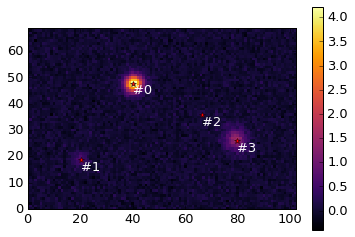

In [3]:
#parents = np.array([len(peaks)>1 for peaks in all_peaks])
parents = np.array([len(peaks)==4 for peaks in all_peaks])
bbox = bboxes[parents][0]
peaks = np.array(list(all_peaks[parents][0]))
# get the peak positions in image coordinates
np.random.seed(1)
img_peaks = np.zeros_like(peaks, dtype=float)
k = len(peaks)
img_peaks[:,0] = peaks[:,0]-bbox[2]+np.random.rand(k)-.5
img_peaks[:,1] = peaks[:,1]-bbox[0]+np.random.rand(k)-.5
img = data[:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
weights = variance[:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
plt.imshow(img[0])
plt.colorbar()
plt.plot(img_peaks[:,0], img_peaks[:,1], 'r*')
for i in range(len(peaks)):
    plt.text(img_peaks[i,0], img_peaks[i,1], '#%d' %i, va='top', ha='left', color='w')
plt.xlim([0,img[0].shape[1]-1])
plt.ylim([0, img[0].shape[0]-1])

In [4]:
l0_thresh=5e-4
l1_thresh = None
strict_constraints = "m"
peaks = img_peaks
B, N, M = img.shape
K = len(peaks)

if l0_thresh is None and l1_thresh is None:
    prox_S = proxmin.operators.prox_plus
else:
    # L0 has preference
    if l0_thresh is not None:
        if l1_thresh is not None:
            logger.warn("weights warning: l1_thresh ignored in favor of l0_thresh")
        prox_S = partial(proxmin.operators.prox_hard, thresh=l0_thresh)
    else:
        prox_S = partial(proxmin.operators.prox_soft_plus, thresh=l1_thresh)
if isinstance(strict_constraints, str):
    if strict_constraints!="m":
        raise ValueError("Monotonicity 'm' is the only allowed strict constraint")
    seeks = [True]*len(peaks)
else:
    seeks = [strict_constraints[pk] for pk in range(peaks)]
prox_S = deblender.proximal.build_prox_monotonic(shape=(N,M), seeks=seeks,
                                                 prox_chain=prox_S)

In [5]:
result = deblender.nmf.deblend(
    img,
    peaks=img_peaks,
    constraints=["S", "S", "S", "S"],
    weights=weights,
    psf=None, max_iter=100,
    e_rel=1e-6,
    psf_thresh=3e-3,
    l0_thresh=5e-4,
    traceback=True,
    monotonicUseNearest=True,
    prox_S=prox_S,
    txy_wait=20
)

INFO:proxmin.algorithms:Completed 101 iterations


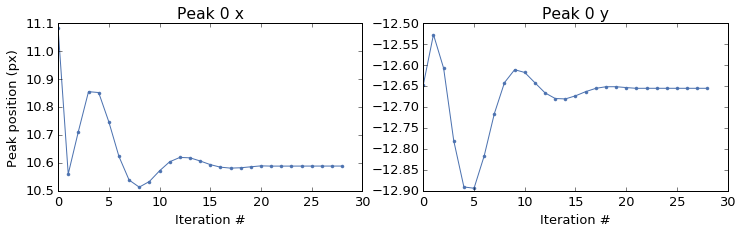

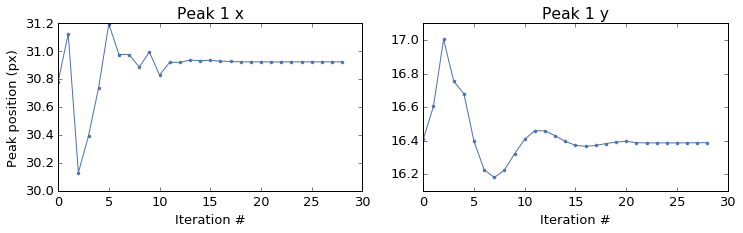

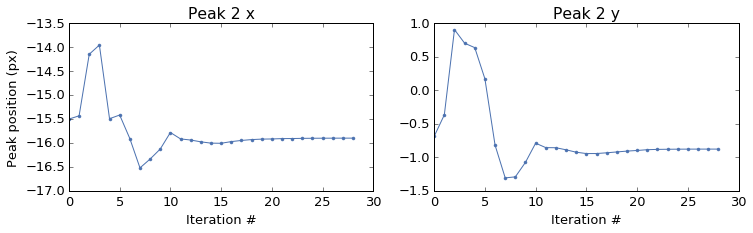

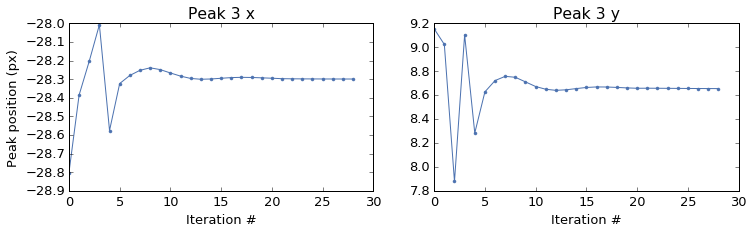

In [6]:
px_hist, py_hist = result.T.get_history()
for k in range(len(peaks)):
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot(px_hist[:,k], '.-')
    ax1.set_title("Peak {0} x".format(k))
    ax2.plot(py_hist[:,k], '.-')
    ax2.set_title("Peak {0} y".format(k))
    ax1.set_xlabel("Iteration #")
    ax2.set_xlabel("Iteration #")
    ax1.set_ylabel("Peak position (px)")
    plt.show()

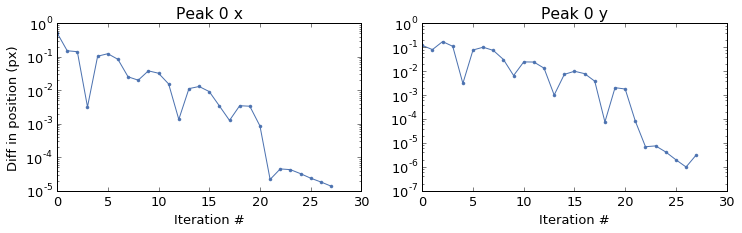

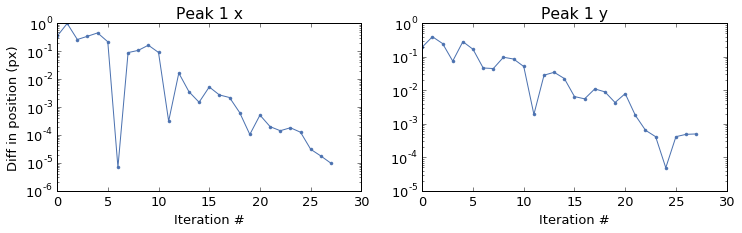

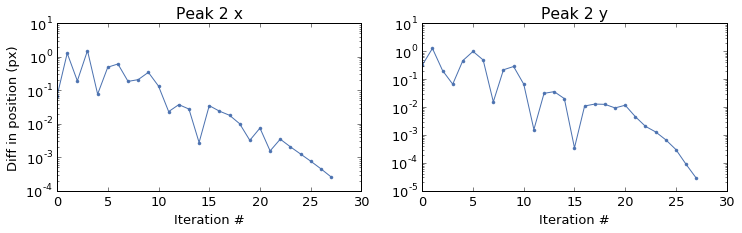

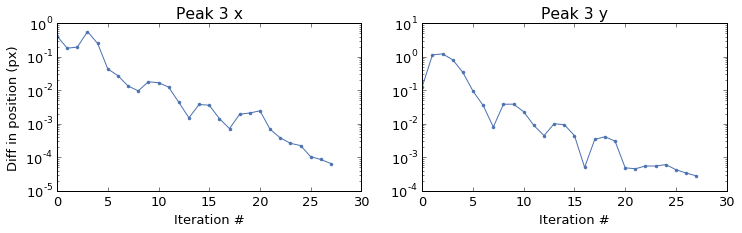

In [7]:
for k in range(len(peaks)):
    fig = plt.figure(figsize=(12,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    dx = np.abs(px_hist[1:,k]-px_hist[:-1,k])
    dy = np.abs(py_hist[1:,k]-py_hist[:-1,k])
    ax1.semilogy(dx, '.-')
    ax1.set_title("Peak {0} x".format(k))
    ax2.semilogy(dy, '.-')
    ax2.set_title("Peak {0} y".format(k))
    ax1.set_xlabel("Iteration #")
    ax2.set_xlabel("Iteration #")
    ax1.set_ylabel("Diff in position (px)")
    plt.show()

In [8]:
import scipy.sparse

Ahist = result.get_history("A")
Shist = result.get_history("S")
model = result.get_model(combine=True)
A,S = result.A, result.S

# Get relative errors
e_rel = 1e-3

# Reprojected image
_img = np.zeros((img.shape[0], model.shape[1], model.shape[2]))
_img[:,:img.shape[1],:img.shape[2]] = img
B, N, M = _img.shape

# Errors in A
eye = scipy.sparse.eye(B,B)
e_A = np.array([list(proxmin.utils.get_variable_errors(eye,
                                                       Ahist["X"][0][i],
                                                       Ahist["Z"][0][i],
                                                       Ahist["U"][0][i],
                                                       e_rel))
                for i in range(len(Ahist["X"][0]))])
e_pri2A = e_A[:,0]
e_dual2A = e_A[:,1]

# Errors in S
L_symm = deblender.nmf.get_constraint_op("S", (N,M), [True]*len(S))
L_symmX = np.array([L_symm.dot(X) for X in Shist["X"][0]])
e_S = np.array([list(proxmin.utils.get_variable_errors(L_symm,
                                                       L_symmX[i],
                                                       Shist["Z"][0][i],
                                                       Shist["U"][0][i],
                                                       e_rel))
                for i in range(len(Ahist["X"][0]))])
e_pri2S = e_S[:,0]
e_dual2S = e_S[:,1]

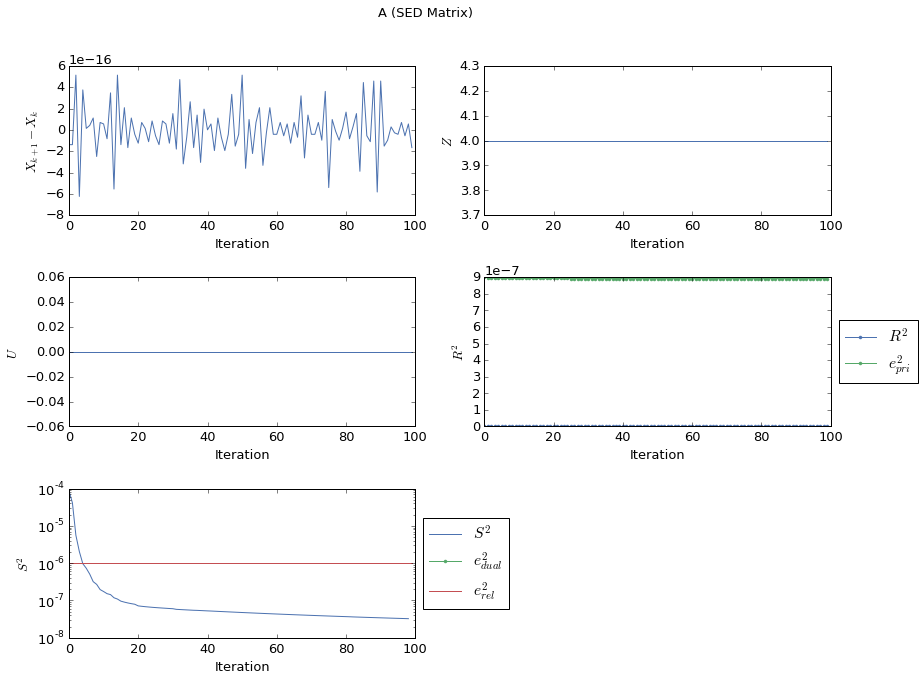

In [9]:
fig = plt.figure(figsize=(12,9))
ax = [fig.add_subplot(3,2,n+1) for n in range(5)]
fig.suptitle("A (SED Matrix)", y=1.05)

ax[0].plot(np.sum((Ahist["X"][0][1:]-Ahist["X"][0][:-1])[:100], axis=(1,2)))
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$X_{{k+1}}-X_k$")

ax[1].plot(np.sum(Ahist["Z"][0][:100], axis=(1,2)))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$Z$")

ax[2].plot(np.sum(Ahist["U"][0][:100], axis=(1,2)))
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("$U$")

ax[3].plot([proxmin.utils.l2sq(R) for R in Ahist["R"][0][:100]], '.-', label="$R^2$")
ax[3].plot(e_pri2A[:100], '.-', label="$e_{{pri}}^2$")
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[3].set_xlabel("Iteration")
ax[3].set_ylabel("$R^2$")

ax[4].semilogy([proxmin.utils.l2sq(S) for S in np.array(Ahist["S"][0][1:100].tolist())], label="$S^2$")
ax[4].plot(e_dual2A[:100], '.-', label="$e_{{dual}}^2$")
ax[4].plot([0,99],[e_rel**2,e_rel**2], label="$e_{{rel}}^2$")
ax[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[4].set_xlabel("Iteration")
ax[4].set_ylabel("$S^2$")

plt.tight_layout()
plt.show()

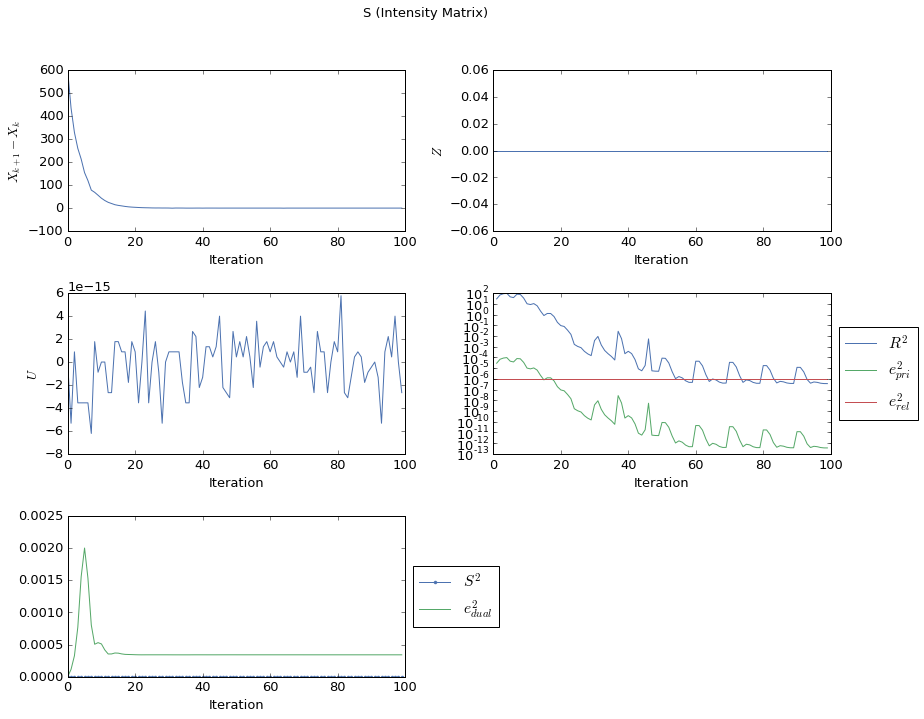

In [10]:
fig = plt.figure(figsize=(12,12))
ax = [fig.add_subplot(4,2,n+1) for n in range(5)]
fig.suptitle("S (Intensity Matrix)", y=1.05)

ax[0].plot(np.sum((Shist["X"][0][1:]-Shist["X"][0][:-1])[:100], axis=(1,2)))
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$X_{{k+1}}-X_k$")

ax[1].plot(np.sum(Shist["Z"][0][:100], axis=(1,2)))
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$Z$")

ax[2].plot(np.sum(Shist["U"][0][:100], axis=(1,2)))
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("$U$")

l2R = np.array([proxmin.utils.l2sq(R) for R in Shist["R"][0][:100]])
ax[3].semilogy(l2R, label="$R^2$")
ax[3].plot(e_pri2S[:100], label="$e_{{pri}}^2$")
ax[3].plot([0,99],[e_rel**2,e_rel**2], label="$e_{{rel}}^2$")
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[3].set_xlabel("Iteration")

"""ax[5].plot([0,99],[e_rel**2,e_rel**2], label="$e_{{rel}}^2$")
ax[5].semilogy(e_pri2S[:100], label="$e_{{pri}}^2$")
ax[5].set_xlabel("Iteration")
ax[5].set_ylabel("$e_{{pri}}^2$")
ax[5].legend()"""

ax[4].plot([proxmin.utils.l2sq(S) for S in np.array(Shist["S"][0][:100].tolist())], '.-', label="$S^2$")
ax[4].plot(e_dual2S[:100], label="$e_{{dual}}^2$")
ax[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[4].set_xlabel("Iteration")

plt.tight_layout()
plt.show()